In [62]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split
import sklearn.datasets as skdata
import matplotlib.pyplot as plt

In [63]:
# Cargamos un dataset de prueba de la librería sklearn
X, y = skdata.fetch_covtype(return_X_y=True, random_state=42)
y = pd.get_dummies(y).to_numpy()
print("Son", X.shape[0], "conjuntos de datos")
print("Existen", X.shape[1], "categorias descriptores")
print("Existen", y.shape[1], "categorias target")

# Separamos la muestra en test y training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Separamos la muestra de training en training y validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=42)

Son 581012 conjuntos de datos
Existen 54 categorias descriptores
Existen 7 categorias target


In [64]:
# Creamos el modelo añadiendo cada capa 
input = tf.keras.Input(name='Input', shape=(X.shape[1],))
h1 = layers.Dense(name='Dense1', units=500, activation='relu')(input)
h2 = layers.Dense(name='Dense2', units=600, activation='relu')(h1)
d1 = layers.Dropout(name='Dropout1', rate=0.3)(h2)
h3 = layers.Dense(name='Dense3', units=650, activation='relu')(d1)
h4 = layers.Dense(name='Dense4', units=400, activation='relu')(h3)
d2 = layers.Dropout(name='Dropout2', rate=0.4)(h4)
h5 = layers.Dense(name='Dense5', units=200, activation='relu')(d2)
d3 = layers.Dropout(name='Dropout3', rate=0.3)(h5)
output = layers.Dense(name='Output', units=y.shape[1], activation='softmax')(h5)

model=tf.keras.models.Model(inputs=input, outputs=output, name="2C_Classification")

# Compilamos empleando el accuracy para medir el funcionamiento del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [65]:
# Mostramos un resumen de nuestro modelo
model.summary()

Model: "2C_Classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 54)]              0         
                                                                 
 Dense1 (Dense)              (None, 500)               27500     
                                                                 
 Dense2 (Dense)              (None, 600)               300600    
                                                                 
 Dropout1 (Dropout)          (None, 600)               0         
                                                                 
 Dense3 (Dense)              (None, 650)               390650    
                                                                 
 Dense4 (Dense)              (None, 400)               260400    
                                                                 
 Dropout2 (Dropout)          (None, 400)         

In [66]:
# Creamos un callback para guardar el mejor modelo
best_model_callback = callbacks.ModelCheckpoint("best_model.h5",
                                                monitor='val_accuracy',
                                                save_best_only=True)

# Creamos un callback para parar de entrenear si la variable a monitorizar no mejora más de un 0.01 en 2 epochs 
early_stopping_callback = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                                            verbose=1, mode='auto')

# Entrenamos el modelo
hist = model.fit(X_train, y_train,
                 validation_data=(X_val, y_val), 
                 epochs=100,        # epoch: número de veces que verá todos los datos
                 batch_size=1000, # batch: número de datos que ve por pasada
                 callbacks=[early_stopping_callback, best_model_callback],
                 verbose=1)


Epoch 1/100
284/285 [============================>.] - ETA: 0s - loss: 5.8308 - accuracy: 0.4867
Epoch 00001: val_loss improved from inf to 0.90198, saving model to best_model.h5
285/285 [==============================] - 13s 45ms/step - loss: 5.8191 - accuracy: 0.4868 - val_loss: 0.9020 - val_accuracy: 0.6037
Epoch 2/100
285/285 [==============================] - ETA: 0s - loss: 0.9256 - accuracy: 0.5979
Epoch 00002: val_loss improved from 0.90198 to 0.79119, saving model to best_model.h5
285/285 [==============================] - 13s 45ms/step - loss: 0.9256 - accuracy: 0.5979 - val_loss: 0.7912 - val_accuracy: 0.6656
Epoch 3/100
284/285 [============================>.] - ETA: 0s - loss: 0.8539 - accuracy: 0.6353
Epoch 00003: val_loss improved from 0.79119 to 0.76512, saving model to best_model.h5
285/285 [==============================] - 13s 46ms/step - loss: 0.8538 - accuracy: 0.6354 - val_loss: 0.7651 - val_accuracy: 0.6714
Epoch 4/100
285/285 [==============================] - E

In [67]:
# Evaluamos el modelo con el dataset de test
score = model.evaluate(X_test,y_test)
score

5447/5447 [==============================] - 12s 2ms/step - loss: 0.8667 - accuracy: 0.5406


[0.8667015433311462, 0.5405785441398621]

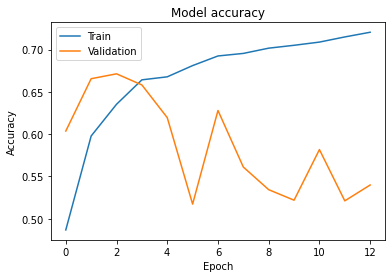

In [68]:
# Mostramos el accuracy en validación y test para las epochs
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [69]:
# Empleamos el modelo para predecir
preds_test = model.predict(X_test)
preds_test.shape

(174304, 7)

In [70]:
# Comprobamos la predicción para un dato en específico
idx_mostrar = 1 # Cambiar
print(y_test[idx_mostrar,])
print(["p(y=%d|x) = %.4f"%(i,p) for i,p in enumerate(preds_test[idx_mostrar])])

[0 1 0 0 0 0 0]
['p(y=0|x) = 0.0775', 'p(y=1|x) = 0.7405', 'p(y=2|x) = 0.0253', 'p(y=3|x) = 0.0004', 'p(y=4|x) = 0.1191', 'p(y=5|x) = 0.0371', 'p(y=6|x) = 0.0002']
